In [1]:
import math
import os
import tarfile
import urllib.request
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils import model_zoo
from torchvision import transforms
from torchvision.datasets import ImageFolder

from poutyne import set_seeds
from poutyne.framework import Model, ModelCheckpoint, CSVLogger

In [ ]:
# Set Pythons's, NumPy's and PyTorch's seeds so that our training are (almost) reproducible.
set_seeds(42)

In [2]:
def download_and_extract_dataset(path):
    tgz_filename = "images.tgz"
    urllib.request.urlretrieve("http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz", tgz_filename)
    os.makedirs(path, exist_ok=True)
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [3]:
def copy(source_path, filenames, dest_path):
    for filename in filenames:
        source = os.path.join(source_path, filename)
        dest = os.path.join(dest_path, filename)
        copyfile(source, dest)

def split_train_valid_test(dataset_path, train_path, valid_path, test_path, train_split=0.6, valid_split=0.2): # test_split=0.2
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        train_class_path = os.path.join(train_path, classname)
        valid_class_path = os.path.join(valid_path, classname)
        test_class_path = os.path.join(test_path, classname)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        dataset_class_path = os.path.join(dataset_path, classname)
        filenames = sorted(filename for filename in os.listdir(dataset_class_path) if not filename.startswith('.'))
        np.random.shuffle(filenames)

        num_examples = len(filenames)
        train_last_idx = math.ceil(num_examples*train_split)
        valid_last_idx = train_last_idx + math.floor(num_examples*valid_split)
        train_filenames = filenames[0:train_last_idx]
        valid_filenames = filenames[train_last_idx:valid_last_idx]
        test_filenames = filenames[valid_last_idx:]
        copy(dataset_class_path, train_filenames, train_class_path)
        copy(dataset_class_path, valid_filenames, valid_class_path)
        copy(dataset_class_path, test_filenames, test_class_path)

We do the split train/valid/test.

In [4]:
base_path = './CUB200'
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [5]:
download_and_extract_dataset(base_path)
split_train_valid_test(dataset_path, train_path, valid_path, test_path)

In [6]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [7]:
# Training hyperparameters
batch_size = 32
learning_rate = 0.1
n_epoch = 30
num_classes = 200

Creation of the PyTorch's datasets for our problem.

In [9]:
norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

We load a pretrained ResNet-18 networks and replace the head with the number of neurons equal to our number of classes.

In [10]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


We freeze the network except for its head.

In [11]:
def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(resnet18)

We define callbacks for saving last epoch, best epoch and logging the results

In [ ]:
callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint('last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint('best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True,
                    restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger('log.tsv', separator='\t'),
]


Finally, we start the training and output its final test loss, accuracy, and micro F1-score.

> Note that the F1-score is quite similar to the accuracy since the dataset is very balanced.

In [13]:
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

model = Model(resnet18, optimizer, loss_function, batch_metrics=['accuracy'], epoch_metrics=['f1'])

model.to(device)

model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch 1/30 30.23s Step 116/116: loss: 4.738788, acc: 6.731549, fscore_micro: 0.067315, val_loss: 3.886809, val_acc: 11.327434, val_fscore_micro: 0.113274
Epoch 1: val_acc improved from -inf to 11.32743, saving file to best_epoch_1.ckpt
Epoch 2/30 30.94s Step 116/116: loss: 3.006773, acc: 33.144093, fscore_micro: 0.331441, val_loss: 3.271729, val_acc: 21.592920, val_fscore_micro: 0.215929
Epoch 2: val_acc improved from 11.32743 to 21.59292, saving file to best_epoch_2.ckpt
Epoch 3/30 33.16s Step 116/116: loss: 2.153980, acc: 52.771019, fscore_micro: 0.527710, val_loss: 2.667525, val_acc: 35.752212, val_fscore_micro: 0.357522
Epoch 3: val_acc improved from 21.59292 to 35.75221, saving file to best_epoch_3.ckpt
Epoch 4/30 33.33s Step 116/116: loss: 1.666963, acc: 64.909435, fscore_micro: 0.649094, val_loss: 2.600248, val_acc: 36.106195, val_fscore_micro: 0.361062
Epoch 4: val_acc improved from 35.75221 to 36.10619, saving file to best_epoch_4.ckpt
Epoch 5/30 33.37s Step 116/116: loss: 1.3

In [14]:
logs = pd.read_csv('log.tsv', sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch       time   lr      loss        acc  fscore_micro  val_loss  \
0       1  30.227874  0.1  4.738788   6.731549      0.067315  3.886809   
1       2  30.940623  0.1  3.006773  33.144093      0.331441  3.271729   
2       3  33.158612  0.1  2.153980  52.771019      0.527710  2.667525   
3       4  33.331771  0.1  1.666963  64.909435      0.649094  2.600248   
4       5  33.366570  0.1  1.336615  73.019735      0.730197  2.355025   
5       6  33.735695  0.1  1.119106  79.264666      0.792647  2.245564   
6       7  33.466024  0.1  0.942244  83.941606      0.839416  2.164859   
7       8  33.016263  0.1  0.834597  86.563936      0.865639  2.138340   
8       9  32.776520  0.1  0.707844  89.943228      0.899432  2.096751   
9      10  33.433662  0.1  0.657364  90.456880      0.904569  2.091874   
10     11  33.290968  0.1  0.579423  92.944039      0.929440  2.079854   
11     12  33.440002  0.1  0.518997  94.484996      0.944850  2.053490   
12     13  32.967461  0.1  0.477968  9

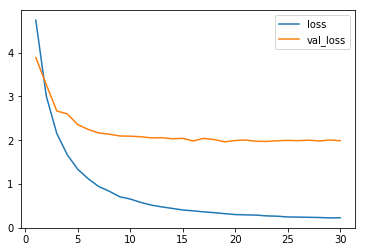

In [15]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

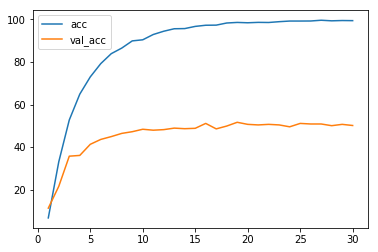

In [16]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Since we have created checkpoints using callbacks, we can restore the best model from those checkpoints and test it.

In [ ]:
resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(resnet18, 'sgd', 'cross_entropy', batch_metrics=['accuracy'], epoch_metrics=['f1'])

model.to(device)

model.load_weights('best_epoch_{epoch}.ckpt'.format(epoch=best_epoch))

test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

